<a href="https://colab.research.google.com/github/andrewRowlinson/data-science/blob/master/football/corner_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplsoccer

In [2]:
from mplsoccer import VerticalPitch
from mplsoccer.heatmap import _BinnedStatisticResult, bin_statistic
from mplsoccer.statsbomb import read_event, EVENT_SLUG
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

In [3]:
df = read_event(f'{EVENT_SLUG}/7478.json',
                related_event_df=False, shot_freeze_frame_df=False,
                tactics_lineup_df=False)['event']

In [4]:
df = df[df.sub_type_name == 'Corner']

In [5]:
p = VerticalPitch(half=True, pad_bottom=-15, line_zorder=2)

In [6]:
path_effects_text = [path_effects.Stroke(linewidth=1.5, foreground='black'),
                     path_effects.Normal()]
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

In [7]:
def bin_statistic_corner(x, y, values=None, dim=None,
                         statistic='count', normalize=False):
    
    x_dim = np.array([dim.center_length,
                      dim.penalty_area_right,
                      dim.right - (2/15 * dim.length),
                      dim.right - dim.length/12 ,
                      dim.right - dim.length / 30,
                      dim.right])
    
    y_dim = np.sort([dim.bottom,
                     dim.top,
                     dim.center_width,
                     dim.center_width - 26/80 * dim.width,
                     dim.center_width + 26/80 * dim.width,
                     dim.center_width - 6/80 * dim.width,
                     dim.center_width + 6/80 * dim.width,
                     dim.center_width - 12/80 * dim.width,
                     dim.center_width + 12/80 * dim.width])

    # sides 1
    bs1 = bin_statistic(x, y, values, dim=dim, statistic=statistic,
                        bins=(x_dim[[0, 1, -1]], y_dim[[0, 1, 2, -3, -2, -1]]),
                       )
    
    # sides 2
    bs2 = bin_statistic(x, y, values, dim=dim, statistic=statistic,
                        bins=(x_dim[[0, 3, -1]], y_dim[[0, 1, 2, -3, -2, -1]]),
                       )
    
    # sides 3
    bs3 = bin_statistic(x, y, values, dim=dim, statistic=statistic,
                        bins=(x_dim[[0, 3, -1]], y_dim[[0, 2, 3, -4, -3, -1]]),
                       )
    
    # infront goal
    bs4 = bin_statistic(x, y, values, dim=dim, statistic=statistic,
                        bins=(x_dim[[0, -3, -2, -1]], y_dim[[0, 3, 4, -4, -1]]),
                       )
    
    # around penalty
    bs5 = bin_statistic(x, y, values, dim=dim, statistic=statistic,
                        bins=(x_dim[[0, 2, 3, -1]], y_dim[[0, 1, 2, -3, -2, -1]]),
                       )
    
    result1 = _BinnedStatisticResult(bs1['statistic'][:1, :],
                                 bs1['x_grid'][:2, :],
                                 bs1['y_grid'][:2, :],
                                 bs1['cx'][:1, :],
                                 bs1['cy'][:1, :],
                                 )._asdict()
    
    result2 = _BinnedStatisticResult(bs1['statistic'][-1:, :],
                                 bs1['x_grid'][-2:, :],
                                 bs1['y_grid'][-2:, :],
                                 bs1['cx'][-1, :],
                                 bs1['cy'][-1:, :],
                                 )._asdict()
    
    result3 = _BinnedStatisticResult(bs2['statistic'][1:2, :],
                                 bs2['x_grid'][1:3, :],
                                 bs2['y_grid'][1:3, :],
                                 bs2['cx'][1:2, :],
                                 bs2['cy'][1:2, :],
                                 )._asdict()
    
    result4 = _BinnedStatisticResult(bs2['statistic'][-2:-1, :],
                                 bs2['x_grid'][-2:, :],
                                 bs2['y_grid'][-3:-1, :],
                                 bs2['cx'][-2:-1, :],
                                 bs2['cy'][-2:-1, :],
                                 )._asdict()
    
    result5 = _BinnedStatisticResult(bs3['statistic'][1:2, 1:],
                                 bs3['x_grid'][-2:, -2:],
                                 bs3['y_grid'][1:3, 1:],
                                 bs3['cx'][-2:-1, -1:],
                                 bs3['cy'][1:2, -1:],
                                 )._asdict()
    
    result6 = _BinnedStatisticResult(bs3['statistic'][-2:-1, 1:],
                                 bs3['x_grid'][-2:, -2:],
                                 bs3['y_grid'][-3:-1, 1:],
                                 bs3['cx'][-2:-1, -1:],
                                 bs3['cy'][-2:-1, -1:],
                                 )._asdict()
    
    result7 = _BinnedStatisticResult(bs4['statistic'][1:3, 1:],
                                 bs4['x_grid'][1:4, 1:4],
                                 bs4['y_grid'][1:4, 1:4],
                                 bs4['cx'][1:3, 1:],
                                 bs4['cy'][1:3, 1:],
                                 )._asdict()
    
    result8 = _BinnedStatisticResult(bs5['statistic'][2:3, :2],
                                 bs5['x_grid'][2:4, :3],
                                 bs5['y_grid'][2:4, :3],
                                 bs5['cx'][2:3, :2],
                                 bs5['cy'][2:3, :2],
                                 )._asdict()
    
    stats = [result1,  result2, result3, result4,
             result5, result6, result7, result8, 
            ]
    
    if normalize:
        total = np.array([stat['statistic'].sum() for stat in stats]).sum()
        for stat in stats:
            stat['statistic'] = stat['statistic'] / total
    
    return stats

In [8]:
left_corner = bin_statistic_corner(df[df.y < 4].end_x, df[df.y < 4].end_y, dim=p.dim, 
                                   statistic='count', normalize=True)
right_corner = bin_statistic_corner(df[df.y > 76].end_x, df[df.y > 76].end_y, dim=p.dim, 
                                    statistic='count', normalize=True)

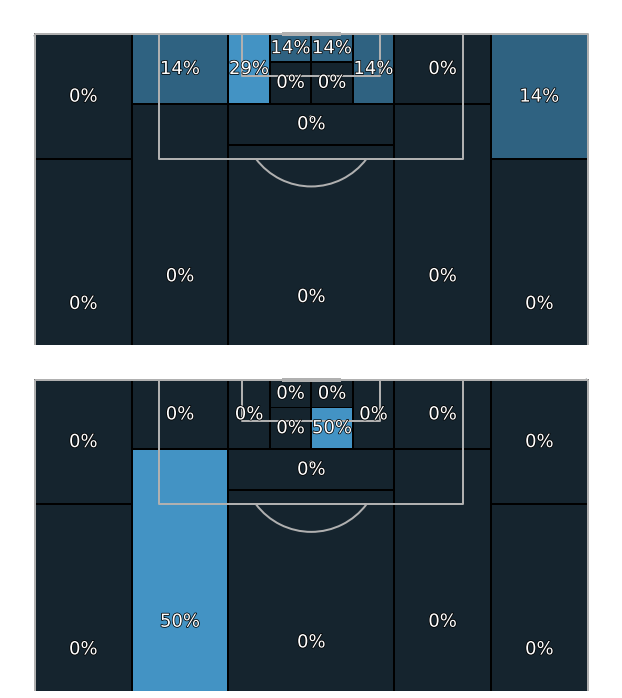

In [9]:
fig, ax = p.grid(nrows=2, figheight=10,
                 grid_height=0.95, space=0.01,
                 title_height=0, endnote_height=0,
                )
p.heatmap_positional(left_corner, cmap=pearl_earring_cmap,
                     ax=ax['pitch'][0], edgecolor='black')
t = p.label_heatmap(left_corner, ax=ax['pitch'][0], va='center', ha='center',
                    color='white', fontsize=18,
                    str_format='{:.0%}', path_effects=path_effects_text)
p.arrows(120, 0, 115, 5, ax=ax['pitch'][0], width=4, color='#15242e', zorder=2)
p.arrows(120, 80, 115, 75, ax=ax['pitch'][1], width=4, color='#15242e', zorder=2)


p.heatmap_positional(right_corner, cmap=pearl_earring_cmap,
                     ax=ax['pitch'][1], edgecolor='black')
t = p.label_heatmap(right_corner, ax=ax['pitch'][1], va='center', ha='center',
                    color='white', fontsize=18,
                    str_format='{:.0%}', path_effects=path_effects_text)